### Build a Basic ChatBot with LangGraph(with GraphAPI)

In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [24]:
class State(TypedDict):
    # Messages have the type list the add_message function in the annotation 
    # defines how this state key should be updated
    # in this case it appends message to the list rather than overwriting it
    messages:Annotated[list, add_messages]



In [3]:
import os 
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
from langchain_deepseek import ChatDeepSeek

llm =  ChatDeepSeek(model="deepseek-chat", api_key=os.getenv('DEEPSEEK_API_KEY_1'), base_url="https://api.deepseek.com", max_retries=2)

In [5]:
## Node Functionality
def chatbot(state:State):
    return {"messages": [llm.invoke(state['messages'])]}

In [6]:
graph_builder = StateGraph(State)
graph_builder.add_node("llmchatbot", chatbot)
graph_builder.add_edge(START, "llmchatbot")
graph_builder.add_edge("llmchatbot", END)

## Compile the graph
graph = graph_builder.compile()

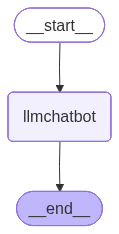

In [7]:
## Visualize the graph 
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [8]:
response = graph.invoke({'messages': 'Hi (en)'})

In [9]:
response['messages'][-1].content

'Hello! 😊 How can I assist you today?'

In [10]:
for event in graph.stream({"messages":"Hi how are you doing today (en)"}):
    for value in event.values():
        print(value['messages'][-1])

content="Hello! I'm doing great, thank you for asking. 😊 How about you? How has your day been so far?" additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 13, 'total_tokens': 39, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 13}, 'model_provider': 'deepseek', 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': '1e099763-34ae-4247-833b-832538cf7fad', 'finish_reason': 'stop', 'logprobs': None} id='lc_run--019b2803-bb99-75c2-8978-98748328861c-0' usage_metadata={'input_tokens': 13, 'output_tokens': 26, 'total_tokens': 39, 'input_token_details': {'cache_read': 0}, 'output_token_details': {}}


### ChatBot With Tool

In [12]:
from langchain_tavily import TavilySearch

os.environ["TAVILY_API_KEY"] = os.getenv('TAVILY_API_KEY')
tool = TavilySearch(max_results=2)
tool.invoke("What does CAG actually mean in llm?")

{'query': 'What does CAG actually mean in llm?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.lumenova.ai/blog/cag-what-is-cache-augumented-generation/',
   'title': 'What Is Cache-Augmented Generation and How to Use It',
   'content': 'CAG is an innovative approach that enhances the efficiency of LLMs by preloading all pertinent information into the model’s context, thereby eliminating the need for real-time data retrieval. CAG does the same for AI by preloading relevant data so responses are faster and more reliable. * **Hybrid Scenarios**: In cases where both preloaded and real-time data are needed, CAG can combine static knowledge with dynamic retrieval. CAG can enhance financial decision-making by preloading foundational knowledge, such as general investment principles, historical market trends, and compliance guidelines, while dynamically retrieving real-time market data. * **Automating Data Preprocessing for CAG**Manually curati

In [44]:
## Custom Function 
def multiply(a: int, b: int) -> int:
    """Multiply a and b

    Args:
        a: First integer
        b: Second integer

    Returns:
        Product of a and b
    """
    return a*b

In [46]:
tools = [tool, multiply]

In [47]:
llm_with_tool = llm.bind_tools(tools)

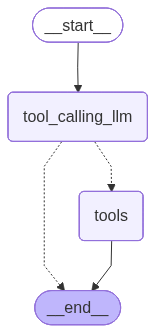

In [ ]:
## Stategraph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

## node definition
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tool.invoke(state['messages'])]}

## Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools", END)
graph = builder.compile()

from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))


In [29]:
response = graph.invoke({"messages": "What is the recent news around AI"})

In [39]:
response['messages'][-1].content

'{"query": "recent AI artificial intelligence news developments 2024", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.foxnews.com/tech/ai-newsletter-hegseth-moves-revolutionize-american-warfighting", "title": "Fox News AI Newsletter: Hegseth moves to revolutionize American warfighting - Fox News", "score": 0.44073462, "published_date": "Fri, 12 Dec 2025 19:49:07 GMT", "content": "- Pentagon launches military AI platform powered by Google Gemini for defense operations  \\n- Disney CEO defends massive AI deal, says creators won\'t be threatened  \\n- Trump says every AI plant being built in US will be self-sustaining with their own electricity", "raw_content": null}, {"url": "https://ts2.tech/en/ai-news-today-december-5-2025-gemini-3-deep-think-anthropics-agentic-ai-and-fresh-security-warnings/", "title": "AI News Today, December 5, 2025: Gemini 3 Deep Think, Anthropic’s Agentic AI, and Fresh Security Warnings - ts2.tech", "score": 0.4391465, 

In [40]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent news around AI
================================== Ai Message ==================================

I'll search for recent news about artificial intelligence to give you an up-to-date overview.
Tool Calls:
  tavily_search (call_00_NcSsRb9ixcEbHxhayONsbGcy)
 Call ID: call_00_NcSsRb9ixcEbHxhayONsbGcy
  Args:
    query: recent AI artificial intelligence news developments 2024
    search_depth: advanced
    time_range: month
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI artificial intelligence news developments 2024", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.foxnews.com/tech/ai-newsletter-hegseth-moves-revolutionize-american-warfighting", "title": "Fox News AI Newsletter: Hegseth moves to revolutionize American warfighting - Fox News", "score": 0.44073

In [49]:
response2 = graph.invoke({'messages' : "what will be 38 multiply by 72"})
for m2 in response2['messages']:
    m2.pretty_print()

================================ Human Message =================================

what will be 38 multiply by 72
================================== Ai Message ==================================

I'll calculate 38 multiplied by 72 for you.
Tool Calls:
  multiply (call_00_s0BKjTI6qPrKRr73tnaKb8vw)
 Call ID: call_00_s0BKjTI6qPrKRr73tnaKb8vw
  Args:
    a: 38
    b: 72
================================= Tool Message =================================
Name: multiply

2736


In [52]:
response3 = graph.invoke({'messages' : "Give me the recent AI news and then multiply 5 by 10"})
for m3 in response3['messages']:
    m3.pretty_print()

================================ Human Message =================================

Give me the recent AI news and then multiply 5 by 10
================================== Ai Message ==================================

I'll help you with both tasks. First, let me get the recent AI news, and then I'll multiply 5 by 10.
Tool Calls:
  tavily_search (call_00_pSdWCVzHioBbz8zmfGfRPEgP)
 Call ID: call_00_pSdWCVzHioBbz8zmfGfRPEgP
  Args:
    query: recent AI news latest developments
    search_depth: advanced
    topic: news
    time_range: week
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news latest developments", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.forbes.com/sites/robtoews/2025/12/14/grading-our-2025-ai-predictions-how-did-we-do/", "title": "Grading Our 2025 AI Predictions: How Did We Do? - Forbes", "score": 0.60861784, "published_date": "Mon, 15 Dec 2025 01:2